In [1]:
%load_ext autoreload
%autoreload 2

TORCH_ACCELERATOR = "cpu"

import os
if TORCH_ACCELERATOR == "cpu":
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

import math
import multiprocessing
import heapq
import dataclasses
import itertools
import collections

import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as T
import numpy as np
import pandas
import matplotlib.pyplot as plt

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger

import torchmetrics
import webdataset as wds
import s2sphere
import tqdm

from mlutil import label_mapping, s2cell_mapping
from datasets import Im2gps2007, World1

LOAD_CHECKPOINT_MAP_LOCATION = {}
if TORCH_ACCELERATOR == "cpu":
    LOAD_CHECKPOINT_MAP_LOCATION = {"map_location": torch.device("cpu")}

torch.cuda.is_available()

False

# Testing

In [2]:
from s2cell_ml import S2CellClassifierTask
from mlutil import geoguessr_score

EARTH_RADIUS = 6371.0

# Run inference on test set. Measure accuracy using PlaNet criteria
def distance_latlng(pred_lat, pred_lng, true_lat, true_lng):
    pred_s2ll = s2sphere.LatLng.from_degrees(pred_lat, pred_lng)
    true_s2ll = s2sphere.LatLng.from_degrees(true_lat, true_lng)
    angle = true_s2ll.get_distance(pred_s2ll)
    return EARTH_RADIUS * angle.radians

@dataclasses.dataclass(order=True)
class DistancePrediction:
    distance: float
    pred_token: str
    lat: float
    lng: float
    img: torch.Tensor=dataclasses.field(compare=False)

def predict_all(model, test_dataloader, mapping, max_steps=None):
    results = {
        "pred_token": [],
        "pred_lat": [],
        "pred_lng": [],
        "true_lat": [],
        "true_lng": [],
        "error": [],
        "score": [],
    }

    least_accurate_n = []

    if max_steps is not None:
        test_dataloader = itertools.islice(test_dataloader, max_steps)

    score = geoguessr_score.GeoguessrScore()

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm.tqdm(test_dataloader):
            logits = model.predict_step(inputs, 0)
            #pred_t = torch.argmax(logits, dim=1)

            pred_ll = model.logits_to_latlng(logits)
            for ix in range(logits.shape[0]):
                pred_token = s2sphere.CellId.from_lat_lng(
                    s2sphere.LatLng.from_degrees(
                        pred_ll[ix][0], pred_ll[ix][1]
                    )
                ).to_token() # TODO
                results["pred_token"].append(pred_token)
                results["pred_lat"].append(pred_ll[ix][0].item())
                results["pred_lng"].append(pred_ll[ix][1].item())

                (true_lat, true_lng) = (targets[ix][0].item(), targets[ix][1].item())
                results["true_lat"].append(true_lat)
                results["true_lng"].append(true_lng)

                score.update(pred_ll[ix].reshape(1, 2), torch.tensor([[true_lat, true_lng]]))
                results["score"].append(score.compute().item())
                score.reset()

                # Maintain list of the most inaccurate predictions
                distance = distance_latlng(pred_ll[ix][0], pred_ll[ix][1], true_lat, true_lng)
                results["error"].append(distance)

                heapq.heappush(
                    least_accurate_n,
                    DistancePrediction(distance, pred_token, true_lat, true_lng, inputs[ix].cpu())
                )
                if len(least_accurate_n) > 10:
                    heapq.heappop(least_accurate_n)

            """
            for ix in range(logits.shape[0]):
                #pred = pred_t[ix]
                #pred_s2cell = mapping.get_name(pred.item())
                #results["pred_token"].append(pred_s2cell)
                token_list = [mapping.get_name(i.item()) for i in torch.nonzero(pred_t[ix])]
                if len(token_list) == 0:
                    pred_token = "1"
                else:
                    pred_token = world1.s2cell_mapping.token_list_to_prediction(token_list).to_token()
                results["pred_token"].append(pred_token)

                pred_s2ll = s2sphere.CellId.from_token(pred_token).to_lat_lng()
                results["pred_lat"].append(pred_s2ll.lat().degrees)
                results["pred_lng"].append(pred_s2ll.lng().degrees)

                (true_lat, true_lng) = (targets[ix][0], targets[ix][1])
                results["true_lat"].append(true_lat)
                results["true_lng"].append(true_lng)

                # Maintain list of the most inaccurate predictions
                distance = distance_latlng(pred_s2ll, true_lat, true_lng)
                results["error"].append(distance)

                heapq.heappush(
                    least_accurate_n,
                    DistancePrediction(distance, pred_token, true_lat, true_lng, inputs[ix].cpu())
                )
                if len(least_accurate_n) > 10:
                    heapq.heappop(least_accurate_n)
            """
    return pandas.DataFrame(results), least_accurate_n

world1 = World1()
im2gps2007 = Im2gps2007()

model = S2CellClassifierTask.load_from_checkpoint(
    "checkpoints/s2cell_ml_efn/efn_v2_s2_train1.ckpt",
    model_name="efn_v2_s2",
    label_mapping=world1.label_mapping,
    overfit=False,
    **LOAD_CHECKPOINT_MAP_LOCATION
)
results, least_accurate_n = predict_all(
    model,
    im2gps2007.test_dataloader_3k(),
    world1.label_mapping,
    #max_steps=1000,
)
results

2788it [04:33, 10.19it/s]


,pred_token,pred_lat,pred_lng,true_lat,true_lng,error,score
0,1000000000000001,0.00000,0.000000,-33.940914,18.374647,4232.587093,1467.193604
1,1000000000000001,0.00000,0.000000,50.484600,5.890045,5641.323315,570.981262
2,1000000000000001,0.00000,0.000000,37.807358,-122.469467,12798.206165,4.724525
3,1000000000000001,0.00000,0.000000,51.499474,-0.119862,5726.491275,539.315002
4,1000000000000001,0.00000,0.000000,38.642952,34.831123,5573.615582,597.476562
...,...,...,...,...,...,...,...
2783,1000000000000001,0.00000,0.000000,51.196239,-1.781898,5695.239062,550.725525
2784,1000000000000001,0.00000,0.000000,-13.311708,48.115936,5502.141211,626.781372
2785,1000000000000001,0.00000,0.000000,51.121410,2.622985,5689.821534,552.727905
2786,1000000000000001,0.00000,0.000000,-37.814667,144.954987,14488.553459,1.522507


In [3]:
#(results["pred_lat"] != 0.0).sum()
results.describe()

,pred_lat,pred_lng,true_lat,true_lng,error,score
count,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000
mean,10.752239,1.268941,35.416288,-8.378735,7886.951899,1689.086374
std,19.896178,36.078860,19.566324,77.762749,3788.745428,4446.415911
min,-42.348866,-149.072968,-54.786335,-157.942474,21.406514,0.068374
25%,0.000000,0.000000,30.609697,-75.166328,5415.843088,14.335434
50%,0.000000,0.000000,40.412964,-0.141068,8045.139735,114.088509
75%,20.213980,0.000000,47.503750,30.313468,11141.358719,664.085861
max,70.008652,152.826462,70.396294,174.765396,19120.594128,24644.037109


In [4]:
# Compute accuracy according to PlaNet criteria
# Street = 1km
# City = 25km
# Region = 200km
# Country = 750km
# Continent = 2500km

def compute_accuracy_planet(results):
    accuracy_planet = {
        "street": 0,
        "city": 0,
        "region": 0,
        "country": 0,
        "continent": 0,
    }

    for r in results.itertuples():
        pred_center = s2sphere.Cell(s2sphere.CellId.from_token(r.pred_token)).get_center()
        pred_latlng = s2sphere.LatLng.from_point(pred_center)
        true_latlng = s2sphere.LatLng.from_degrees(r.true_lat, r.true_lng)
        angle = true_latlng.get_distance(pred_latlng)
        distance_km = 6378.0 * 2 * math.pi * angle.radians
        
        if distance_km <= 1:
            accuracy_planet["street"] += 1
        if distance_km <= 25:
            accuracy_planet["city"] += 1
        if distance_km <= 200:
            accuracy_planet["region"] += 1
        if distance_km <= 750:
            accuracy_planet["country"] += 1
        if distance_km <= 2500:
            accuracy_planet["continent"] += 1

    for k in accuracy_planet.keys():
        accuracy_planet[k] /= len(results.index)
        accuracy_planet[k] *= 100.0 # percent

    return accuracy_planet

compute_accuracy_planet(results)

{'street': 0.0,
 'city': 0.0,
 'region': 0.07173601147776185,
 'country': 0.7890961262553802,
 'continent': 2.008608321377331}

In [15]:
# Compute max possible accuracy with our current set of s2 cells
all_s2_cell_centers = {
    token: s2sphere.LatLng.from_point(s2sphere.Cell(s2sphere.CellId.from_token(token)).get_center())
    for token in world1.label_mapping.name_to_label.keys()
}

def best_cell_for(lat, lng):
    true_latlng = s2sphere.LatLng.from_degrees(lat, lng)
    all_distances = [
        (token, true_latlng.get_distance(center).radians)
        for token, center in all_s2_cell_centers.items()
    ]
    return min(all_distances, key=lambda x: x[1])[0]

def perfect_test_results():
    test_dataloader = world1.overfit_dataloader_one()

    results = {
        "pred_token": [],
        "true_lat": [],
        "true_lng": [],
    }

    for inputs, targets in tqdm.tqdm(test_dataloader):
        for ix in range(inputs.shape[0]):
            pred_s2cell = best_cell_for(targets[0][0], targets[0][1])
            results["pred_token"].append(pred_s2cell)
            results["true_lat"].append(targets[0][0])
            results["true_lng"].append(targets[0][1])
    df = pandas.DataFrame(results)
    print(df)
    return df

compute_accuracy_planet(perfect_test_results())

50it [00:07,  6.27it/s]

    pred_token         true_lat          true_lng
0         31dc   tensor(0.9086)  tensor(104.5182)
1         31dc   tensor(0.9086)  tensor(104.5182)
2         31dc   tensor(0.9086)  tensor(104.5182)
3         31dc   tensor(0.9086)  tensor(104.5182)
4         31dc   tensor(0.9086)  tensor(104.5182)
..         ...              ...               ...
785      89c23  tensor(40.2379)  tensor(-74.2094)
786      89c23  tensor(40.2379)  tensor(-74.2094)
787      89c23  tensor(40.2379)  tensor(-74.2094)
788      89c23  tensor(40.2379)  tensor(-74.2094)
789      89c23  tensor(40.2379)  tensor(-74.2094)

[790 rows x 3 columns]


{'street': 0.0,
 'city': 10.126582278481013,
 'region': 27.088607594936708,
 'country': 65.56962025316456,
 'continent': 100.0}

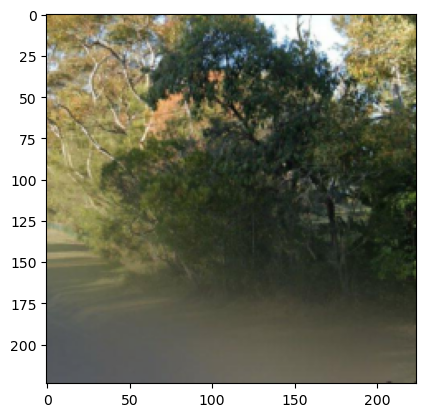

Distance(km):  225.54779696882358
Pred(token):  6b0c
True(latlng):  tensor(-33.6954) tensor(151.2642)


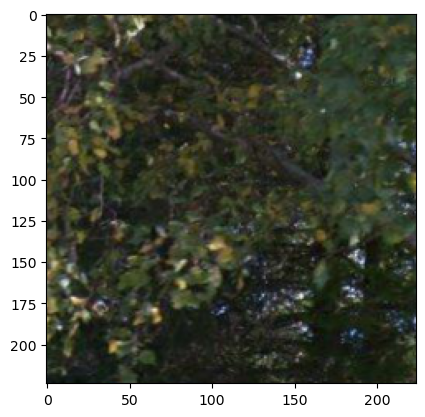

Distance(km):  951.1462373260633
Pred(token):  47a85c
True(latlng):  tensor(60.1129) tensor(19.8837)


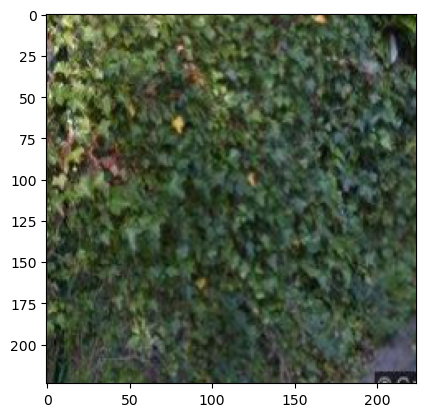

Distance(km):  1047.5175279645757
Pred(token):  4764
True(latlng):  tensor(50.7520) tensor(4.3372)


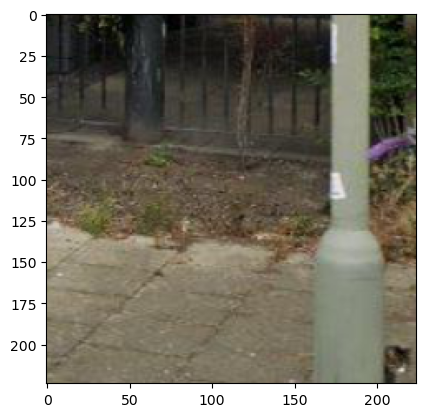

Distance(km):  5723.287406781392
Pred(token):  1
True(latlng):  tensor(51.4706) tensor(-0.1737)


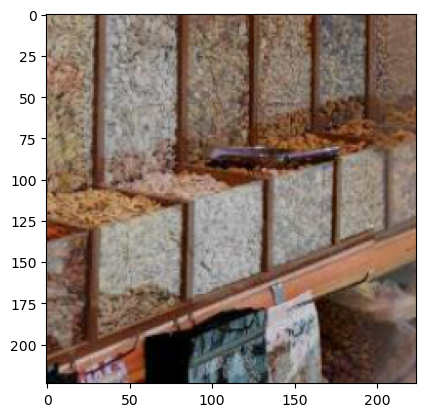

Distance(km):  5921.448621354778
Pred(token):  1
True(latlng):  tensor(33.2368) tensor(44.3323)


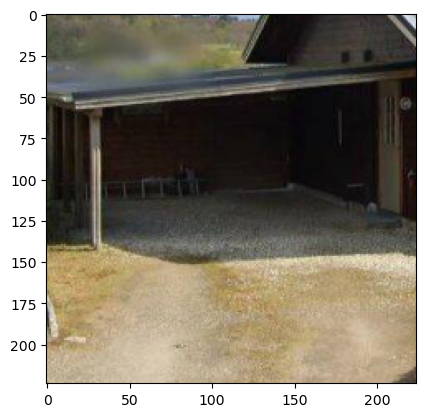

Distance(km):  6199.992941473904
Pred(token):  1
True(latlng):  tensor(55.1252) tensor(10.2319)


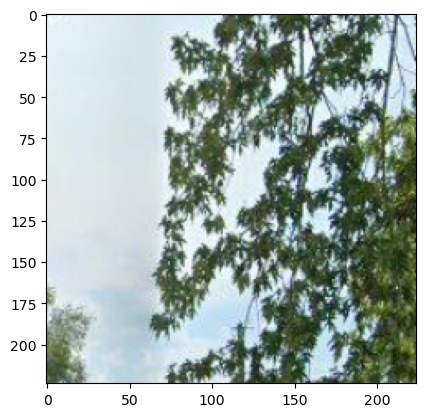

Distance(km):  8308.648907960749
Pred(token):  476c
True(latlng):  tensor(40.9230) tensor(-98.3703)


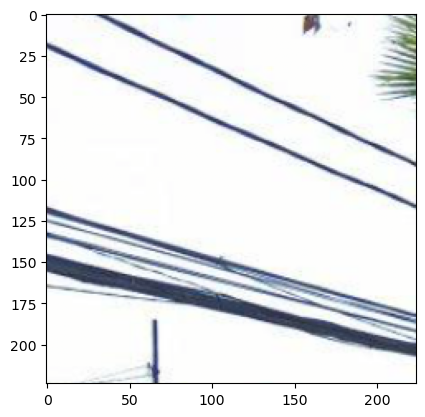

Distance(km):  9260.219776377893
Pred(token):  6d34
True(latlng):  tensor(-33.4484) tensor(-70.5841)


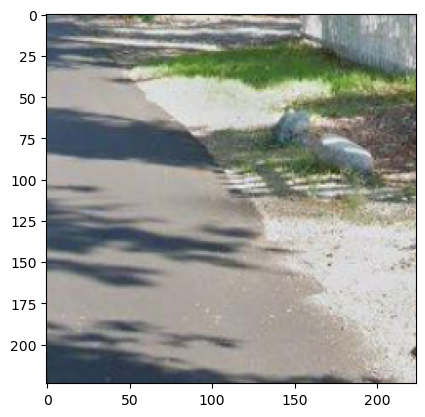

Distance(km):  10126.912585536247
Pred(token):  131c
True(latlng):  tensor(40.5374) tensor(-122.3689)


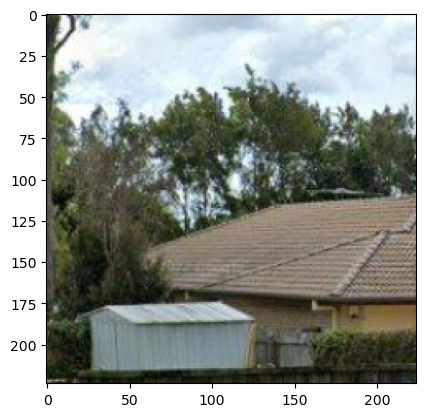

Distance(km):  15817.380483886778
Pred(token):  1
True(latlng):  tensor(-27.4164) tensor(152.9642)


In [19]:
# Visualize the least accurate predictions
def visualize_predictions(heap):
    inv_normalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

    while len(heap) > 0:
        example = heapq.heappop(heap)

        image = inv_normalize(example.img)
        plt.imshow(image.permute(1, 2, 0))
        plt.show()

        print("Distance(km): ", example.distance)
        print("Pred(token): ", example.pred_token)
        print("True(latlng): ", example.lat, example.lng)

visualize_predictions(list(least_accurate_n))

In [45]:
class S2Annotator:
    def __init__(self, mapping):
        self.cell_set = set([s2sphere.CellId.from_token(token).id() for token in mapping.name_to_label.keys()])

    def get_cell(self, lat, lng):
        cell_id = s2sphere.CellId.from_lat_lng(s2sphere.LatLng.from_degrees(lat, lng))
        while cell_id.id() not in self.cell_set:
            if cell_id.level() == 0:
                return None
            cell_id = cell_id.parent()
        return cell_id.to_token()

# Return a list of predictions and a list of corresponding true labels
def prediction_labels(annotator, results):
    pred_labels = []
    true_labels = []
    for r in results.itertuples():
        true_token = annotator.get_cell(r.true_lat, r.true_lng)
        if true_token is None:
            continue
        
        pred_labels.append(im2gps2007.mapping.get_label(r.pred_token))
        true_labels.append(im2gps2007.mapping.get_label(true_token))

    return pred_labels, true_labels


# Compute and display confusion matrix
def confusion_matrix(annotator, results):
    pred_labels, true_labels = prediction_labels(annotator, results)
    confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(im2gps2007.mapping))
    return confmat(torch.Tensor(pred_labels), torch.Tensor(true_labels))

annotator = S2Annotator(im2gps2007.mapping)
cm = confusion_matrix(annotator, results)

#import seaborn
#seaborn.heatmap(cm.numpy(), annot=True)
#plt.matshow(cm.numpy())
#plt.show()
cm

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 2,  ..., 0, 0, 0],
        [0, 0, 3,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 3, 0],
        [0, 0, 0,  ..., 0, 0, 4]])

In [49]:
pred_labels, true_labels = prediction_labels(annotator, results)
len(pred_labels), len(true_labels)

(106622, 106622)

In [54]:
# Print 10 least accurate predictions, 10 most confused labels
def print_least_accurate_confused(pred_labels, true_labels):
    confused_counts = collections.Counter()
    for pred, true in zip(pred_labels, true_labels):
        if pred != true:
            confused_counts[true] += 1

    confused_labels = sorted(confused_counts.items(), key=lambda x: x[1], reverse=True)
    print("Most confused labels")
    for label, count in confused_labels[:10]:
        print(im2gps2007.mapping.get_name(label), count)

    #least_accurate = []
    #for pred, true in zip(pred_labels, true_labels):
    #    if pred != true:
    #        least_accurate.append((pred, true))

    #print("Least accurate predictions")
    #for pred, true in least_accurate[:10]:
    #    print(pred, true)

print_least_accurate_confused(pred_labels, true_labels)

Most confused labels
3442a9 488
88f505 349
35b2704 322
47b7 315
88dd4 312
357cb 307
60188bf 289
1dcc4 280
3baf 279
390d 270


In [56]:
# Print top most confused pairs
def print_top_confused_cm(cm):
    confusion = np.copy(cm.numpy())
    num_printed = 0
    while num_printed < 20:
        max_ix = np.unravel_index(np.argmax(confusion), confusion.shape)
        if max_ix[0] == 0:
            break
        if max_ix[0] == max_ix[1]:
            confusion[max_ix] = 0
            continue
        print(
            f"true = {im2gps2007.mapping.get_name(int(max_ix[0]))},"\
            f"pred = {im2gps2007.mapping.get_name(int(max_ix[1]))},"\
            f"count = {confusion[max_ix]}"
        )
        confusion[max_ix] = 0
        num_printed += 1

print_top_confused_cm(cm)

true = 47b7,pred = 4cc91bc,count = 61
true = 1dcc4,pred = 12cd,count = 47
true = 3442a9,pred = 4cc91a5,count = 46
true = 1499,pred = 12cd,count = 42
true = 133b4,pred = 12cd,count = 41
true = 134b,pred = 12cd,count = 39
true = 134d,pred = 12cd,count = 37
true = 0daf,pred = 12cd,count = 36
true = 3442a9,pred = 4cc91bc,count = 36
true = 88dd4,pred = 12cd,count = 35
true = 14a1bd1,pred = 12cd,count = 34
true = 470b,pred = 479f,count = 34
true = 88f505,pred = 12cd,count = 34
true = 12a4a2f4,pred = 12cd,count = 33
true = 14a1bd3,pred = 12cd,count = 33
true = 132a55,pred = 479f,count = 32
true = 1335,pred = 12cd,count = 32
true = 60014,pred = 4cc91bc,count = 32
true = 3442a9,pred = 12cd,count = 30
true = 88dd4,pred = 80dcc,count = 30
